# Prediction using the bottom up method, taking into account function names

This notebook details the process of prediction from which homework a notebook came after featurizing the notebook using the bottom up method. This is done by gathering all templates in each notebook after running the algorithm, then using countvectorizer to featurize the notebooks, and finally using random forests to make the prediction

In [1]:
import sys
home_directory = '/dfs/scratch2/fcipollone'
sys.path.append(home_directory)
import numpy as np
from nbminer.notebook_miner import NotebookMiner

hw_filenames = np.load('../homework_names_jplag_combined_per_student.npy')
hw_notebooks = [[NotebookMiner(filename) for filename in temp[:59]] for temp in hw_filenames]

In [2]:
from nbminer.pipeline.pipeline import Pipeline
from nbminer.features.features import Features
from nbminer.preprocess.get_ast_features import GetASTFeatures
from nbminer.preprocess.get_imports import GetImports
from nbminer.preprocess.resample_by_node import ResampleByNode
from nbminer.encoders.ast_graph.ast_graph import ASTGraphReducer
from nbminer.preprocess.feature_encoding import FeatureEncoding
from nbminer.encoders.cluster.kmeans_encoder import KmeansEncoder
from nbminer.results.similarity.jaccard_similarity import NotebookJaccardSimilarity
from nbminer.results.prediction.corpus_identifier import CorpusIdentifier
a = Features(hw_notebooks[2], 'hw2')
a.add_notebooks(hw_notebooks[3], 'hw3')
a.add_notebooks(hw_notebooks[4], 'hw4')
a.add_notebooks(hw_notebooks[5], 'hw5')
gastf = GetASTFeatures()
rbn = ResampleByNode()
gi = GetImports()
agr = ASTGraphReducer(a, threshold=8, split_call=True)
ci = CorpusIdentifier()
pipe = Pipeline([gastf, rbn, gi, agr, ci])
a = pipe.transform(a)

236
236
236
236
236


In [3]:
import tqdm
X, y = ci.get_data_set()
similarities = np.zeros((len(X), len(X)))
for i in tqdm.tqdm(range(len(X))):
    for j in range(len(X)):
        if len(set.union(set(X[i]), set(X[j]))) == 0:
            continue
        similarities[i][j] = len(set.intersection(set(X[i]), set(X[j]))) / (len(set.union(set(X[i]), set(X[j]))))

100%|██████████| 236/236 [00:01<00:00, 160.87it/s]


# Inter and Intra Similarities

The first measure that we can use to determine if something reasonable is happening is to look at, for each homework, the average similarity of two notebooks both pulled from that homework, and the average similarity of a notebook pulled from that homework and any notebook in the corpus not pulled from that homework. These are printed below

In [4]:
def get_avg_inter_intra_sims(X, y, val):
    inter_sims = []
    intra_sims = []
    for i in range(len(X)):
        for j in range(i+1, len(X)):
            if y[i] == y[j] and y[i] == val:
                intra_sims.append(similarities[i][j])
            else:
                inter_sims.append(similarities[i][j])
    return np.array(intra_sims), np.array(inter_sims)

for i in np.unique(y):
    intra_sims, inter_sims = get_avg_inter_intra_sims(X, y, i)
    print('Mean intra similarity for hw',i,'is',np.mean(intra_sims),'with std',np.std(intra_sims))
    print('Mean inter similarity for hw',i,'is',np.mean(inter_sims),'with std',np.std(inter_sims))
    print('----')

Mean intra similarity for hw 0 is 0.2174842523251329 with std 0.05698355280291586
Mean inter similarity for hw 0 is 0.16171729519473005 with std 0.05544712077359082
----
Mean intra similarity for hw 1 is 0.20182027971693817 with std 0.06662724565337202
Mean inter similarity for hw 1 is 0.162747352350371 with std 0.055620895083606035
----
Mean intra similarity for hw 2 is 0.19093488712188447 with std 0.06843993544707581
Mean inter similarity for hw 2 is 0.1634631718180729 with std 0.05590364627069331
----
Mean intra similarity for hw 3 is 0.2092891346665037 with std 0.0636621994831903
Mean inter similarity for hw 3 is 0.16225620315867617 with std 0.05546888343822935
----


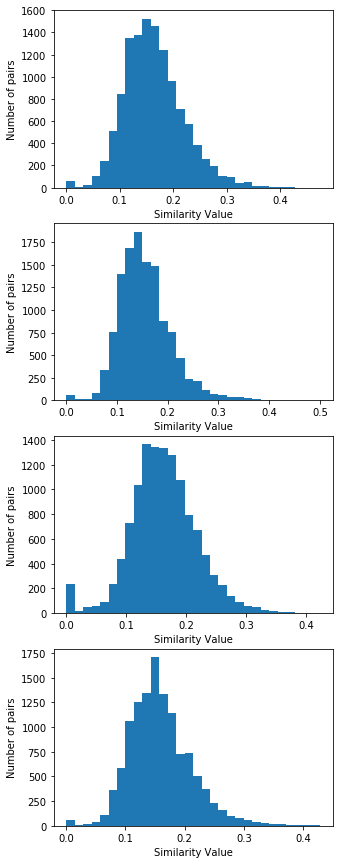

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 5, 15
def get_all_sims(X, y, val):
    sims = []
    for i in range(len(X)):
        for j in range(i+1, len(X)):
            if y[i] == val or y[j] == val:
                sims.append(similarities[i][j])
    return sims
fig, axes = plt.subplots(4)
for i in range(4):
    axes[i].hist(get_all_sims(X,y,i), bins=30)
    axes[i].set_xlabel("Similarity Value")
    axes[i].set_ylabel("Number of pairs")

## Sims color coded

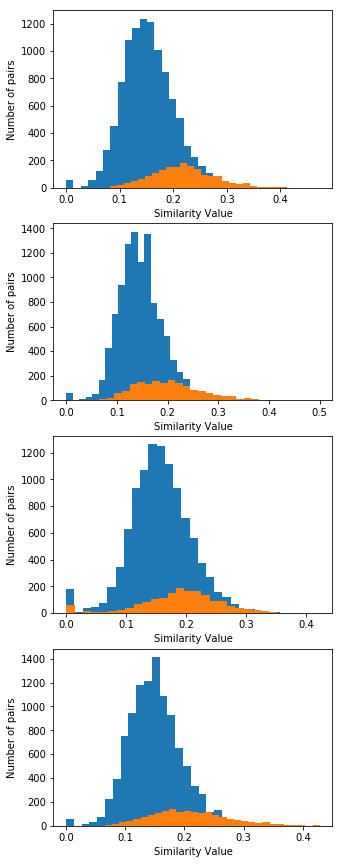

In [41]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 5, 15
def get_all_sims(X, y, val):
    sims = []
    sims_outer = []
    for i in range(len(X)):
        for j in range(i+1, len(X)):
            if y[i] == val or y[j] == val:
                if y[i] == y[j]:
                    sims.append(similarities[i][j])
                else:
                    sims_outer.append(similarities[i][j])
    return sims,sims_outer

fig, axes = plt.subplots(4)
for i in range(4):
    axes[i].hist(get_all_sims(X,y,i)[1], bins=30)
    axes[i].hist(get_all_sims(X,y,i)[0], bins=30)
    axes[i].set_xlabel("Similarity Value")
    axes[i].set_ylabel("Number of pairs")

# Actual Prediction

While the above results are helpful, it is better to use a classifier that uses more information. The setup is as follows:

1. Split the data into train and test
2. Vectorize based on templates that exist
3. Build a random forest classifier that uses this feature representation, and measure the performance

In [6]:
import sklearn
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

X, y = ci.get_data_set()
countvec = sklearn.feature_extraction.text.CountVectorizer()
X_list = [" ".join(el) for el in X]
countvec.fit(X_list)
X = countvec.transform(X_list)

p = np.random.permutation(len(X.todense()))
X = X.todense()[p]
y = np.array(y)[p]

clf = sklearn.ensemble.RandomForestClassifier(n_estimators=400, max_depth=3)
scores = cross_val_score(clf, X, y, cv=10)
print(scores)
print(np.mean(scores))


[0.83333333 1.         0.875      0.91666667 0.95833333 0.95833333
 0.91666667 0.875      0.875      0.95      ]
0.9158333333333332


In [7]:
X.shape

(236, 417)

# Clustering

Lastly, we try unsupervised learning, clustering based on the features we've extracted, and measure using sillouette score.

In [8]:
X, y = ci.get_data_set()
countvec = sklearn.feature_extraction.text.CountVectorizer()
X_list = [" ".join(el) for el in X]
countvec.fit(X_list)
X = countvec.transform(X_list)

In [9]:
clusterer = sklearn.cluster.KMeans(n_clusters = 4).fit(X)
cluster_score = (sklearn.metrics.silhouette_score(X, clusterer.labels_))
cheat_score = (sklearn.metrics.silhouette_score(X, y))

print('Silhouette score using the actual labels:', cheat_score)
print('Silhouette score using the cluster labels:', cluster_score)

Silhouette score using the actual labels: -0.010996880373224218
Silhouette score using the cluster labels: 0.16302921247804447


(-2, 5)

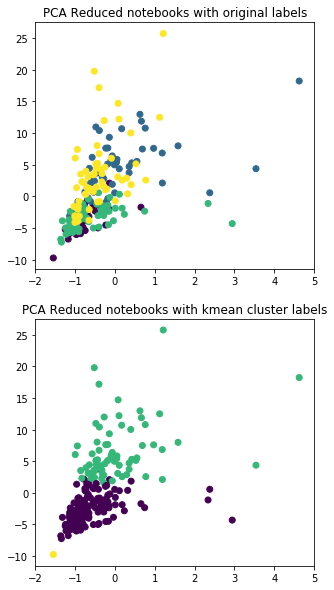

In [10]:
x_reduced = sklearn.decomposition.PCA(n_components=2).fit_transform(X.todense())
plt.rcParams['figure.figsize'] = 5, 10
fig, axes = plt.subplots(2)
axes[0].scatter(x_reduced[:,0], x_reduced[:,1], c=y)
axes[0].set_title('PCA Reduced notebooks with original labels')
axes[0].set_xlim(left=-2, right=5)
axes[1].scatter(x_reduced[:,0], x_reduced[:,1], c=clusterer.labels_)
axes[1].set_title('PCA Reduced notebooks with kmean cluster labels')
axes[1].set_xlim(left=-2, right=5)

# Trying to restrict features
The problem above is that there are too many unimportant features -- all this noise makes it hard to seperate the different classes. To try to counteract this, I'll try ranking the features using tfidf and only take some of them

In [46]:
X, y = ci.get_data_set()
tfidf = sklearn.feature_extraction.text.TfidfVectorizer()
X_list = [" ".join(el) for el in X]
tfidf.fit(X_list)
X = tfidf.transform(X_list)
#X = X.todense()

In [47]:
feature_array = np.array(tfidf.get_feature_names())
tfidf_sorting = np.argsort(X.toarray()).flatten()[::-1]
top_n = feature_array[tfidf_sorting][:50]
print(top_n)

['template_4492' 'template_2' 'template_4393' 'template_4424'
 'template_1131' 'template_358' 'template_4577' 'template_4334'
 'template_4458' 'template_4493' 'template_355' 'template_1'
 'template_300' 'template_4652' 'template_1110' 'template_1089'
 'template_350' 'template_6287' 'template_4420' 'template_4414'
 'template_4416' 'template_4417' 'template_4418' 'template_4376'
 'template_4374' 'template_4385' 'template_4372' 'template_4425'
 'template_4426' 'template_4427' 'template_4428' 'template_4429'
 'template_4430' 'template_4432' 'template_4371' 'template_4422'
 'template_4413' 'template_4388' 'template_4410' 'template_4389'
 'template_4391' 'template_4392' 'template_4384' 'template_4382'
 'template_4381' 'template_4394' 'template_4396' 'template_4397'
 'template_4399' 'template_4380']


In [48]:
top_n = [el[1] for el in sra[:15]]
print(top_n)

['template_2', 'template_4492', 'template_300', 'template_1', 'template_4614', 'template_4652', 'template_4799', 'template_1110', 'template_1096', 'template_1127', 'template_4518', 'template_6433', 'template_352', 'template_4516', 'template_4374']


In [49]:
X, y = ci.get_data_set()
countvec = sklearn.feature_extraction.text.CountVectorizer()

X_list = [" ".join([val for val in el if val in top_n]) for el in X]
countvec.fit(X_list)
X = countvec.transform(X_list)
X = X.todense()

(236, 2)


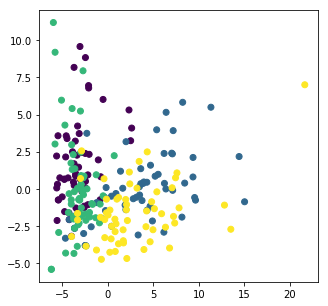

In [50]:
x_reduced = sklearn.decomposition.PCA(n_components=2).fit_transform(X)
print(x_reduced.shape)
plt.rcParams['figure.figsize'] = 5, 5
plt.scatter(x_reduced[:,0], x_reduced[:,1], c=y)

In [51]:
cheat_score = (sklearn.metrics.silhouette_score(x_reduced, y))
print(cheat_score)

0.0002634317729376597


# T-SNE

In [52]:
X, y = ci.get_data_set()
tfidf = sklearn.feature_extraction.text.TfidfVectorizer()
X_list = [" ".join(el) for el in X]
tfidf.fit(X_list)
X = tfidf.transform(X_list)
#X = X.todense()

In [53]:
# This is a recommended step when using T-SNE
x_reduced = sklearn.decomposition.PCA(n_components=50).fit_transform(X.todense())

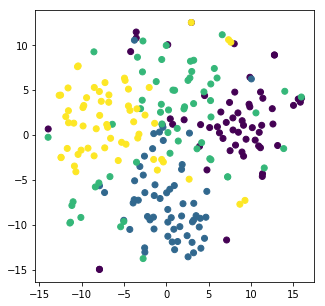

In [54]:
from sklearn.manifold import TSNE
tsn = TSNE(n_components=2)
x_red = tsn.fit_transform(x_reduced)
plt.scatter(x_red[:,0], x_red[:,1], c=y)

In [56]:
cheat_score = (sklearn.metrics.silhouette_score(x_red, y))
print(cheat_score)

0.17149098


In [58]:
clusterer = sklearn.cluster.KMeans(n_clusters = 4).fit(x_red)
cluster_score = (sklearn.metrics.silhouette_score(X, clusterer.labels_))
print(cluster_score)

0.02037744067644545


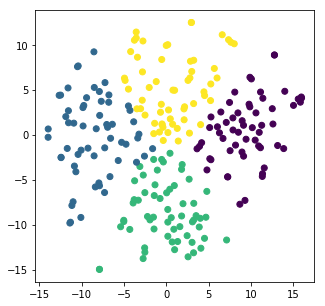

In [59]:
plt.scatter(x_red[:,0], x_red[:,1], c=clusterer.labels_)

# What's happening

Figuring out what is going on is a bit difficult, but we can look at the top templates generated from the random forest, and see why they might have been chosen

In [16]:
'''
Looking at the output below, it's clear that the bottom up method is recognizing very specific
structures of ast graph, which makes sense because some structures are exactly repeated in
homeworks. For example:

treatment = pd.Series([0]*4 + [1]*2)

is a line in all of the homework one notebooks, and the top feature of the random forest
(at time of running) is 

var = pd.Series([0] * 4 + [1] * 2)

Note that the bottom up method does not even take the specific numbers into account, but only
the operations.
'''

clf.fit(X,y)
fnames= countvec.get_feature_names()
clfi = clf.feature_importances_
sa = []
for i in range(len(clfi)):
    sa.append((clfi[i], fnames[i]))
sra = [el for el in reversed(sorted(sa))]
import astor
for temp in sra:
    temp = temp[1]
    print(temp, agr.templates.get_examples(temp)[1])
    for i in range(5):
        print ('\t',astor.to_source(agr.templates.get_examples(temp)[0][i]))

template_2 1131
	 from module import import as import

	 from module import import as import

	 from module import import as import

	 from module import import as import

	 from module import import as import

template_4492 139
	 var.fit(var, var)

	 var.fit(var, var)

	 var.fit(var, var)

	 var.fit(var, var)

	 var.fit(var, var)

template_300 530
	 var

	 var

	 var

	 var

	 var

template_1 1571
	 import import as import

	 import import as import

	 import import as import

	 import import as import

	 import import as import

template_4614 76
	 var = var.drop(['string', 'string', 'string', 'string', 'string'], axis=1)

	 var = var.drop(['string', 'string', 'string', 'string', 'string'], axis=1)

	 var = var.drop(['string', 'string'], axis=1)

	 var = var.drop(['string', 'string', 'string'], axis=1)

	 var = var.drop(['string', 'string'], axis=1)

template_4652 48
	 var = pd.read_csv('string', sep='string')

	 var = pd.read_csv('string', sep='string', encoding='string')

	 var = pd